# Hierarchical Reconciliation - Example on the Australian Tourism Dataset

In this notebook we demonstrate hierarchical reconciliation. We will use the Australian tourism dataset (originally coming from [here](https://robjhyndman.com/publications/hierarchical-tourism/)), which contains monthly tourism numbers, disaggrated by region, travel reason and city/non-city type of tourism.

We will use techniques presented in Rob Hyndman's book [here](https://otexts.com/fpp3/hierarchical.html), and we will see that reconciling forecasts can be done in a few lines of code using Darts.

First, some imports:

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally

fix_pythonpath_if_working_locally()
%matplotlib inline

In [2]:
from itertools import product

import matplotlib.pyplot as plt

from darts import concatenate
from darts.dataprocessing.transformers import MinTReconciliator
from darts.datasets import AustralianTourismDataset
from darts.metrics import mae
from darts.models import LinearRegressionModel, Theta

/Users/dennisbader/miniconda3/envs/darts310_test/lib/python3.10/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


## Loading Data

Below, we load a single `TimeSeries`, which is multivariate (i.e., contains multiple components). We simply use the `AustralianTourismDataset` Darts dataset for simplicity, but we could also use `TimeSeries.from_dataframe(df)`, providing a DataFrame `df` containing one column per component and one row per timestamp.

In [3]:
tourism_series = AustralianTourismDataset().load()

This series contains several components:

* One component named `"Total"`,
* One component per region (`"NSW"`, `"VIC"`, etc)
* One component per tourism reason (`"Hol"` for holiday, `"Bus"` for business, etc)
* One component per (region, reason) pair (named `"NSW - hol"`, `"NSW - bus"`, etc)
* One component per (region, reason, \<city\>) tuple, where \<city\> is either `"city"` or `"noncity"`. So these are components named `"NSW - hol - city"`, `"NSW - hol - noncity"`, `"NSW - bus - city"`, etc.

Let's plot a few of those:

<Axes: xlabel='time'>

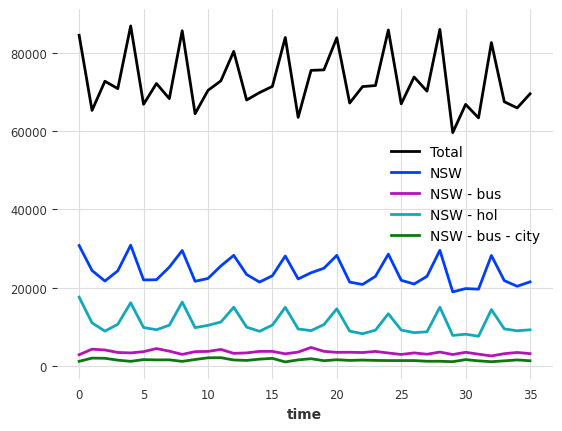

In [4]:
tourism_series[["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]].plot()

## Inspecting the Hierarchy

Some of these components add up in certain ways. For instance, the sum of the holiday tourism done in New South Wales can be decomposed as the sum of "city" and "noncity" holiday New South Wales tourism:

<Axes: xlabel='time'>

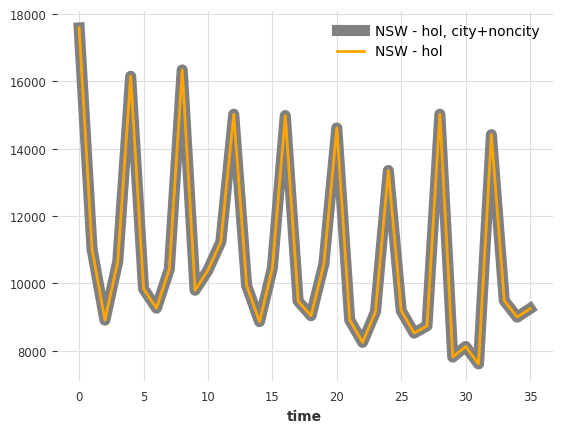

In [5]:
sum_city_noncity = (
    tourism_series["NSW - hol - city"] + tourism_series["NSW - hol - noncity"]
)
sum_city_noncity.plot(label="NSW - hol, city+noncity", lw=8, color="grey")
tourism_series["NSW - hol"].plot(color="orange")

Similarly, both the sum over regions and over reasons add up to the total:

<Axes: xlabel='time'>

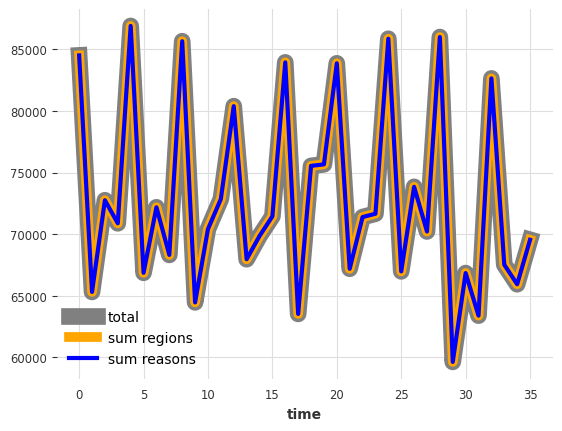

In [6]:
reasons = ["Hol", "VFR", "Bus", "Oth"]
regions = ["NSW", "VIC", "QLD", "SA", "WA", "TAS", "NT"]
city_labels = ["city", "noncity"]

tourism_series["Total"].plot(label="total", lw=12, color="grey")
tourism_series[regions].sum(axis=1).plot(label="sum regions", lw=7, color="orange")
tourism_series[reasons].sum(axis=1).plot(label="sum reasons", lw=3, color="blue")

So overall our hierarchy looks as follows:

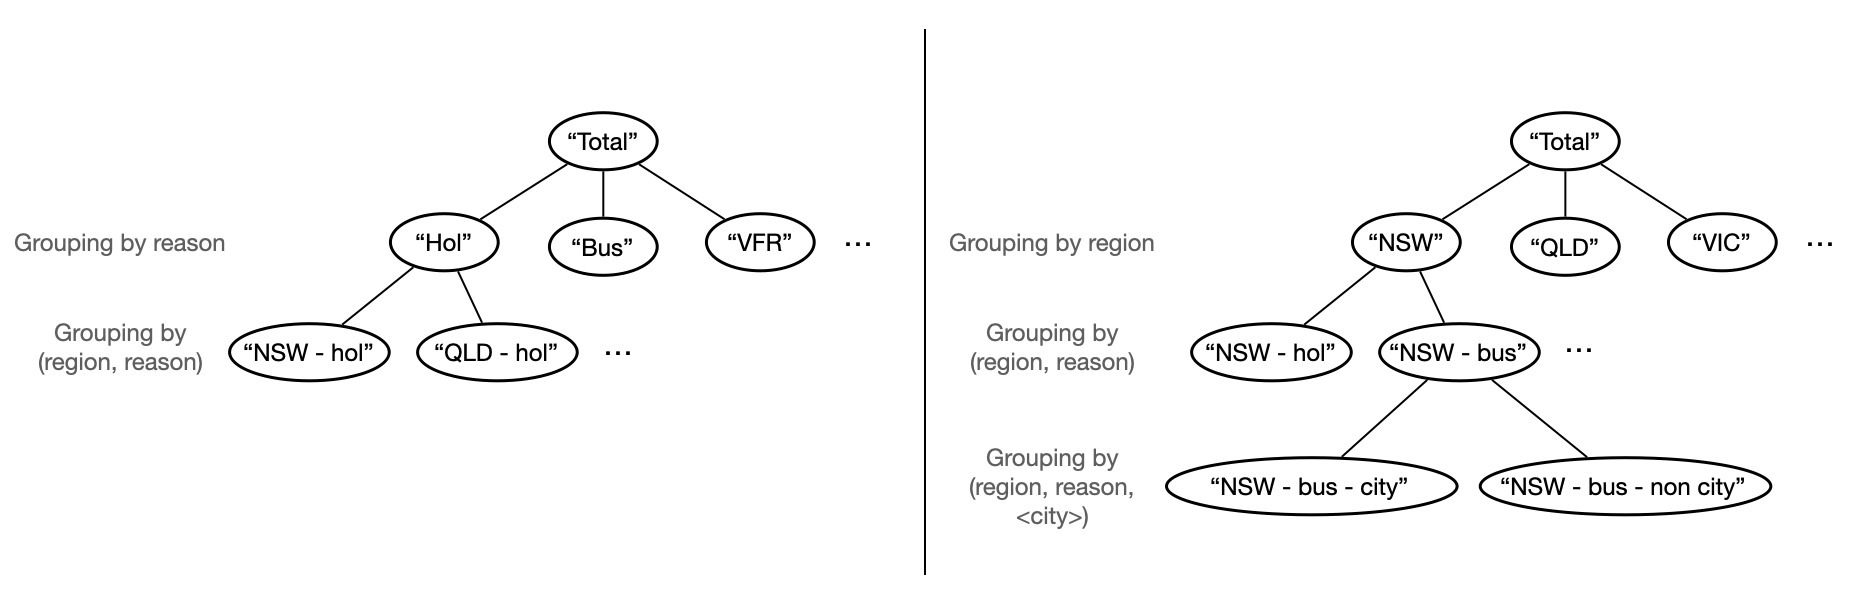

## Encoding the Hierarchy

We will now encode the hierarchy itself in a way that Darts understands. This is simple: the hierarchy is simply represented as a `dict`, where the keys are component names, and the values are lists containing this component's parent(s) in the hierarchy.

For example, referring to the figure above:

* `"Hol"` is mapped to `["Total"]`, as it is a child of `"Total"` in the left tree.
* `"NSW - hol"` is mapped to `["Hol", "NSW"]`, as it is a child of both `"Hol"` (in the left tree), and `"NSW"` (in the right tree).
* `"NSW - bus - city"` is mapped to `["NSW - bus"]` as it is a child of `"NSW - bus"` in the right tree.
* etc...

So all components except `"Total"` will appear as a key in the hierarchy dictionary.
As we have quite a few components (96), we will not build this dict by hand, but rather programmatically:

In [7]:
hierarchy = dict()

# Fill in grouping by reason
for reason in reasons:
    hierarchy[reason] = ["Total"]

# Fill in grouping by region
for region in regions:
    hierarchy[region] = ["Total"]

# Fill in grouping by (region, reason)
for region, reason in product(regions, reasons):
    hierarchy[f"{region} - {reason.lower()}"] = [reason, region]

# Fill in grouping by (region, reason, <city>)
for region, reason, city in product(regions, reasons, city_labels):
    hierarchy[f"{region} - {reason.lower()} - {city}"] = [
        f"{region} - {reason.lower()}"
    ]

As a sanity check, let's see what a few of the components map to in the hierarchy:

In [8]:
for component in ["Hol", "NSW - hol", "NSW - bus - city"]:
    print(f"{component} -> {hierarchy[component]}")

Hol -> ['Total']
NSW - hol -> ['Hol', 'NSW']
NSW - bus - city -> ['NSW - bus']


Good, that looks as expected.

In Darts, hierarchies are a property of `TimeSeries` objects.
We can now embed our hierarchy in our `TimeSeries`. We do this using the `with_hierarchy()` method, but we could also specify the hierarchy at the series construction; for instance providing a `hierarchy` to the `TimeSeries.from_dataframe()` factory method.

In [9]:
tourism_series = tourism_series.with_hierarchy(hierarchy)

## Forecasting Using a Multivariate Model

Now we have a multivariate time series, which contains the hierarchy information. Let's split it in train / eval parts. We will keep the last 12 months as a validation set.

In [10]:
train, val = tourism_series[:-12], tourism_series[-12:]

Getting forecasts is now as easy as using one of Darts models supporting multivariate series:

In [11]:
model = LinearRegressionModel(lags=12)
model.fit(train)
pred = model.predict(n=len(val))

Let's look at our forecasts:

<Axes: xlabel='time'>

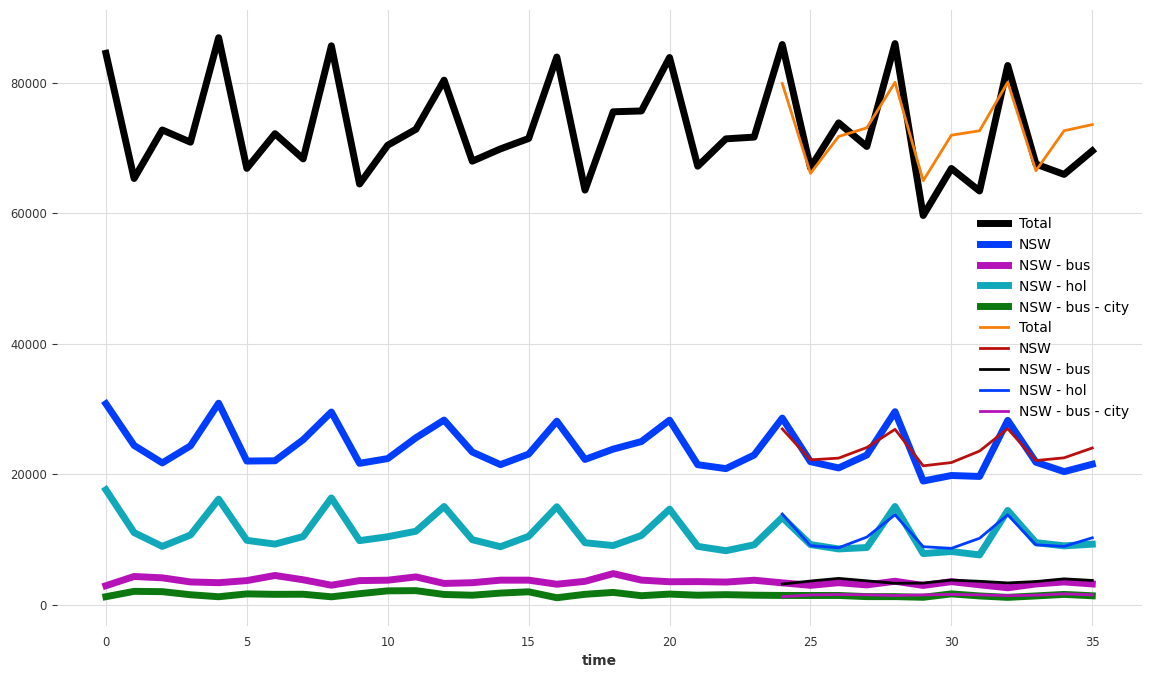

In [12]:
components_to_show = ["Total", "NSW", "NSW - bus", "NSW - hol", "NSW - bus - city"]
plt.figure(figsize=(14, 8))
tourism_series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)

Let's also compute the accuracy at the different levels (MAE, averaged over several components):

In [13]:
# we pre-generate some of the components' names
regions_reasons_comps = list(
    map(lambda t: f"{t[0]} - {t[1].lower()}", product(regions, reasons))
)

regions_reasons_city_comps = list(
    map(
        lambda t: f"{t[0]} - {t[1].lower()} - {t[2]}",
        product(regions, reasons, city_labels),
    )
)


def measure_mae(pred):
    def print_mae_on_subset(subset, name):
        print(f"mean MAE on {name}: {mae(pred[subset], val[subset]):.2f}")

    print_mae_on_subset(["Total"], "total")
    print_mae_on_subset(reasons, "reasons")
    print_mae_on_subset(regions, "regions")
    print_mae_on_subset(regions_reasons_comps, "(region, reason)")
    print_mae_on_subset(regions_reasons_city_comps, "(region, reason, city)")


measure_mae(pred)

mean MAE on total: 4311.00
mean MAE on reasons: 1299.87
mean MAE on regions: 815.08
mean MAE on (region, reason): 315.89
mean MAE on (region, reason, city): 191.85


## Reconciling Forecasts

First, let's see whether our current "raw" forecasts add up:

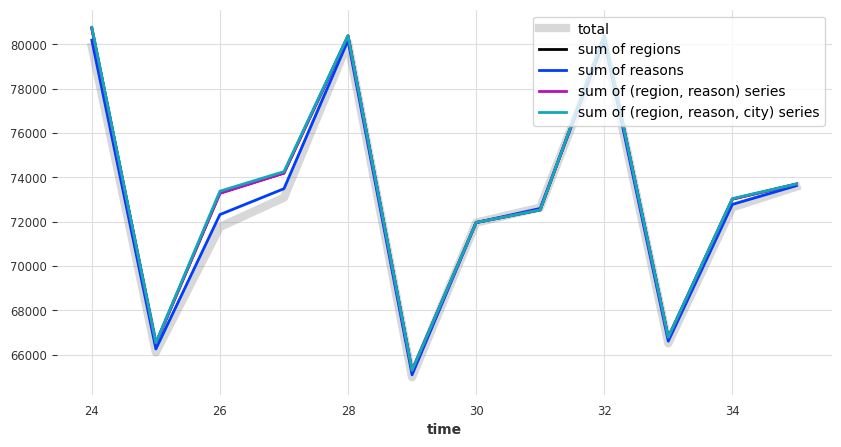

In [14]:
def plot_forecast_sums(pred_series):
    plt.figure(figsize=(10, 5))

    pred_series["Total"].plot(label="total", lw=6, alpha=0.3, color="grey")
    pred_series[regions].sum(axis=1).plot(label="sum of regions")
    pred_series[reasons].sum(axis=1).plot(label="sum of reasons")
    pred_series[regions_reasons_comps].sum(axis=1).plot(
        label="sum of (region, reason) series"
    )
    pred_series[regions_reasons_city_comps].sum(axis=1).plot(
        label="sum of (region, reason, city) series"
    )

    legend = plt.legend(loc="best", frameon=1)
    frame = legend.get_frame()
    frame.set_facecolor("white")


plot_forecast_sums(pred)

It seems that they don't. So let's reconcile them.
We will use some transformers available in `darts.dataprocessing.transformers` to do that. These transformers can perform *posthoc* reconciliation (i.e., reconcile forecasts after they have been obtained). We have at our disposal the following methods:

* `BottomUpReconciliator` performs bottom-up reconciliation, simply resetting each component in the hierarchy as the sum of its children components ([API documentation](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.reconciliation.html#darts.dataprocessing.transformers.reconciliation.BottomUpReconciliator)).
* `TopDownReconciliator` performs top-down reconciliation, which breaks down the aggregate forecasts down the hierarchy using historical proportions. This transformer requires calling `fit()` with the historical values (i.e., the training series) in order to learn these proportions ([API documentation](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.reconciliation.html#darts.dataprocessing.transformers.reconciliation.TopDownReconciliator)).
* `MinTReconciliator` is a technique to perform "optimal" reconciliation, as detailed [here](https://otexts.com/fpp3/reconciliation.html#the-mint-optimal-reconciliation-approach). This transformer can work in a few different ways listed in the [API Documentation](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.transformers.reconciliation.html#darts.dataprocessing.transformers.reconciliation.MinTReconciliator).

Below, we use the `wls_val` variant of `MinTReconciliator`:

In [15]:
reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(train)
reconcilied_preds = reconciliator.transform(pred)

Let's now check whether the reconciled forecasts sum up as we expect:

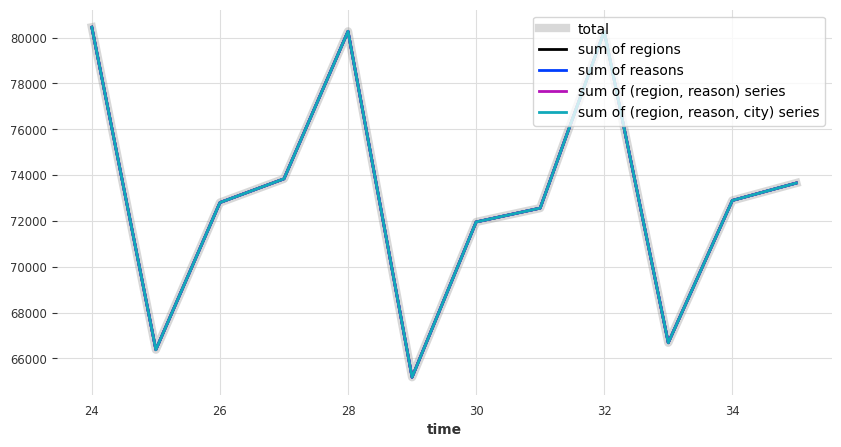

In [16]:
plot_forecast_sums(reconcilied_preds)

It looks good - and how about the MAE errors:

In [17]:
measure_mae(reconcilied_preds)

mean MAE on total: 4205.92
mean MAE on reasons: 1294.87
mean MAE on regions: 810.68
mean MAE on (region, reason): 315.11
mean MAE on (region, reason, city): 191.36


Compared to before, the MAE slightly increased (e.g., on the total level), whereas it slightly decreased on some other more granular levels. This is typical of reconciliation: it can increase the error, but also decrease it in some cases.

## Alternative: Forecasting Components Independently
Above, we simply fit a single multivariate model on our multivariate series. This means that the forecasts for each dimension consumes the (lagged) values of all other dimensions. Below, for the sake of example, we repeat the experiment but using "local" models forecasting each component independently. We use a simple `Theta` model, and concatenate all the forecasts in a single multivariate `TimeSeries`:

In [18]:
preds = []
for component in tourism_series.components:
    model = Theta()
    model.fit(train[component])
    preds.append(model.predict(n=len(val)))

pred = concatenate(preds, axis="component")

/Users/dennisbader/miniconda3/envs/darts310_test/lib/python3.10/site-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


Let's plot a few forecasts, and show the MAE errors:

mean MAE on total: 3294.38
mean MAE on reasons: 1204.76
mean MAE on regions: 819.13
mean MAE on (region, reason): 329.39
mean MAE on (region, reason, city): 195.16


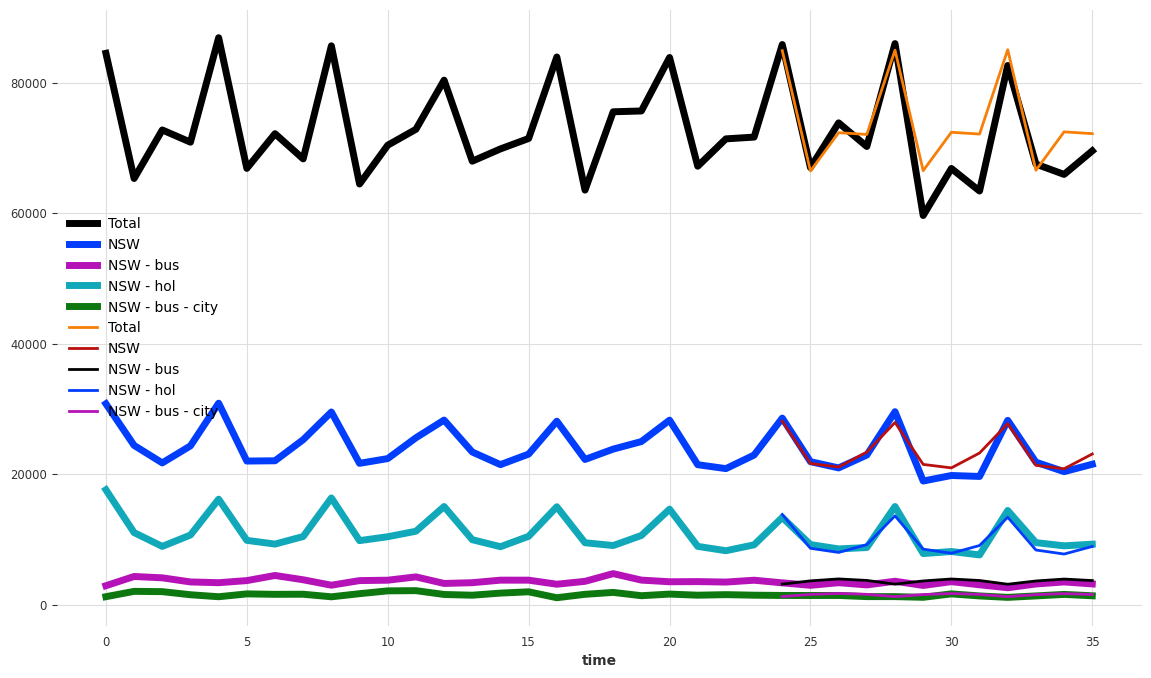

In [19]:
plt.figure(figsize=(14, 8))
tourism_series[components_to_show].plot(lw=5)
pred[components_to_show].plot(lw=2)
measure_mae(pred)

As expected, these forecasts don't add up either:

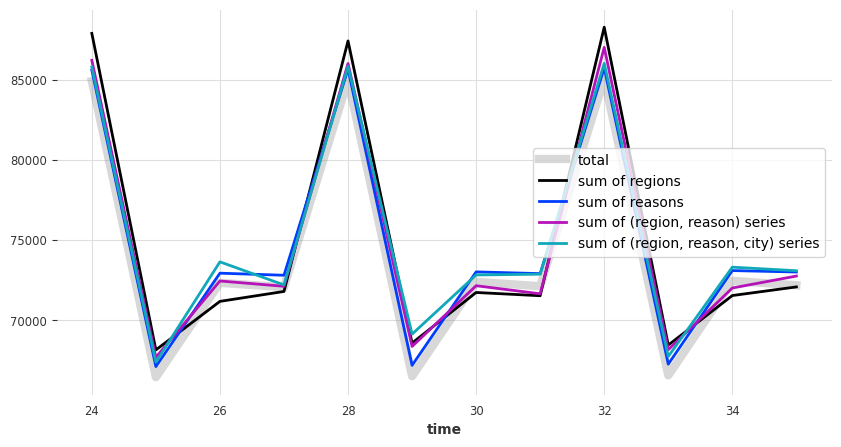

In [20]:
plot_forecast_sums(pred)

Let's make them add up using a `MinTReconciliator`:

mean MAE on total: 3349.33
mean MAE on reasons: 1215.91
mean MAE on regions: 782.26
mean MAE on (region, reason): 316.39
mean MAE on (region, reason, city): 199.92


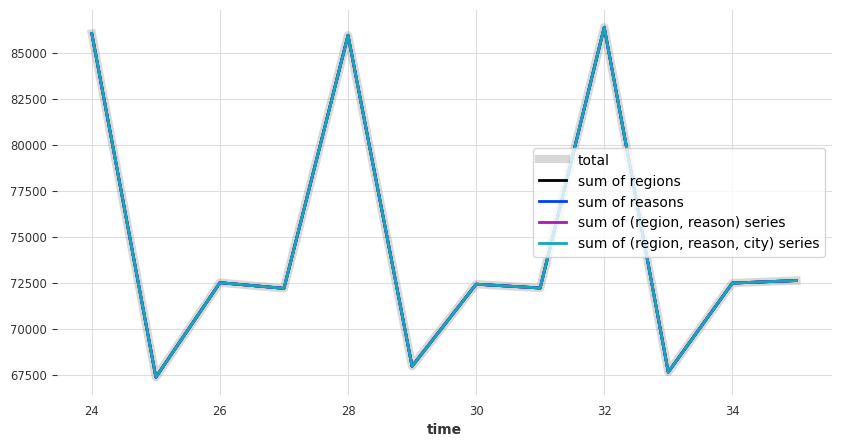

In [21]:
reconciliator = MinTReconciliator(method="wls_val")
reconciliator.fit(train)
reconcilied_preds = reconciliator.transform(pred)

plot_forecast_sums(reconcilied_preds)
measure_mae(reconcilied_preds)